# Deep Autoencoding Gaussian Mixture Model for Unsupervised Anomaly Detection

In [1]:
import numpy as np 
import pandas as pd
import torch
# from data_loader import *
# from main import *
from tqdm import tqdm
from PIL import Image
import os

In [2]:
root = '/home/genta/dataset/DAGM2007/Class1/'
fnames = os.listdir(root)

np_imgs = []
for fname in fnames:
    im = Image.open(os.path.join(root, fname))
    np_imgs.append(np.asarray(im))
    
np_imgs = np.asarray(np_imgs).astype(np.float32)/255.
print(np_imgs.shape)
np_imgs_mean = np_imgs.mean(axis=0)
np_imgs_var = np_imgs.var(axis=0)
np_imgs = (np_imgs - np_imgs_mean) / np.sqrt(np_imgs_var)
np_imgs = np_imgs.astype(np.float64)

np_imgs = np_imgs.reshape(-1, 512*512)

(1000, 512, 512)


In [3]:
# %load main.py
import os
import argparse
# from solver import Solver
# from data_loader import get_loader
from torch.backends import cudnn
from utils import *

def str2bool(v):
    return v.lower() in ('true')

def main(config):
    # For fast training
    cudnn.benchmark = True

    # Create directories if not exist
    mkdir(config.log_path)
    mkdir(config.model_save_path)

    data_loader = get_loader(config.data_path, batch_size=config.batch_size, mode=config.mode)
    
    # Solver
    solver = Solver(data_loader, vars(config))

    if config.mode == 'train':
        solver.train()
    elif config.mode == 'test':
        solver.test()

    return solver

In [4]:
# %load solver.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import time
import datetime
from torch.autograd import grad
from torch.autograd import Variable
from model import *
import matplotlib.pyplot as plt
from utils import *
# from data_loader import *
import IPython
from tqdm import tqdm

class Solver(object):
    DEFAULTS = {}   
    def __init__(self, data_loader, config):
        # Data loader
        self.__dict__.update(Solver.DEFAULTS, **config)
        self.data_loader = data_loader

        # Build tensorboard if use
        self.build_model()
        if self.use_tensorboard:
            self.build_tensorboard()

        # Start with trained model
        if self.pretrained_model:
            self.load_pretrained_model()

    def build_model(self):
        # Define model
        self.dagmm = DaGMM(input_size=self.data_loader.dataset.D, n_gmm=self.gmm_k)

        # Optimizers
        self.optimizer = torch.optim.Adam(self.dagmm.parameters(), lr=self.lr)

        # Print networks
        self.print_network(self.dagmm, 'DaGMM')

        if torch.cuda.is_available():
            self.dagmm.cuda()

    def print_network(self, model, name):
        num_params = 0
        for p in model.parameters():
            num_params += p.numel()
        print(name)
        print(model)
        print("The number of parameters: {}".format(num_params))

    def load_pretrained_model(self):
        self.dagmm.load_state_dict(torch.load(os.path.join(
            self.model_save_path, '{}_dagmm.pth'.format(self.pretrained_model))))

        print("phi", self.dagmm.phi,"mu",self.dagmm.mu, "cov",self.dagmm.cov)

        print('loaded trained models (step: {})..!'.format(self.pretrained_model))

    def build_tensorboard(self):
        from logger import Logger
        self.logger = Logger(self.log_path)

    def reset_grad(self):
        self.dagmm.zero_grad()

    def to_var(self, x, volatile=False):
        if torch.cuda.is_available():
            x = x.cuda()
        return Variable(x, volatile=volatile)

    def train(self):
        iters_per_epoch = len(self.data_loader)

        # Start with trained model if exists
        if self.pretrained_model:
            start = int(self.pretrained_model.split('_')[0])
        else:
            start = 0

        # Start training
        iter_ctr = 0
        start_time = time.time()



        self.ap_global_train = np.array([0,0,0])
        for e in range(start, self.num_epochs):
            for i, (input_data, labels) in enumerate(tqdm(self.data_loader)):
                iter_ctr += 1
                start = time.time()

                input_data = self.to_var(input_data)

                total_loss,sample_energy, recon_error, cov_diag = self.dagmm_step(input_data)
                # Logging
                loss = {}
                loss['total_loss'] = total_loss.data.item()
                loss['sample_energy'] = sample_energy.item()
                loss['recon_error'] = recon_error.item()
                loss['cov_diag'] = cov_diag.item()



                # Print out log info
                if (i+1) % self.log_step == 0:
                    elapsed = time.time() - start_time
                    total_time = ((self.num_epochs*iters_per_epoch)-(e*iters_per_epoch+i)) * elapsed/(e*iters_per_epoch+i+1)
                    epoch_time = (iters_per_epoch-i)* elapsed/(e*iters_per_epoch+i+1)
                    
                    epoch_time = str(datetime.timedelta(seconds=epoch_time))
                    total_time = str(datetime.timedelta(seconds=total_time))
                    elapsed = str(datetime.timedelta(seconds=elapsed))

                    lr_tmp = []
                    for param_group in self.optimizer.param_groups:
                        lr_tmp.append(param_group['lr'])
                    tmplr = np.squeeze(np.array(lr_tmp))

                    log = "Elapsed {}/{} -- {} , Epoch [{}/{}], Iter [{}/{}], lr {}".format(
                        elapsed,epoch_time,total_time, e+1, self.num_epochs, i+1, iters_per_epoch, tmplr)

                    for tag, value in loss.items():
                        log += ", {}: {:.4f}".format(tag, value)

                    IPython.display.clear_output()
                    print(log)

                    if self.use_tensorboard:
                        for tag, value in loss.items():
                            self.logger.scalar_summary(tag, value, e * iters_per_epoch + i + 1)
                    else:
                        plt_ctr = 1
                        if not hasattr(self,"loss_logs"):
                            self.loss_logs = {}
                            for loss_key in loss:
                                self.loss_logs[loss_key] = [loss[loss_key]]
                                plt.subplot(2,2,plt_ctr)
                                plt.plot(np.array(self.loss_logs[loss_key]), label=loss_key)
                                plt.legend()
                                plt_ctr += 1
                        else:
                            for loss_key in loss:
                                self.loss_logs[loss_key].append(loss[loss_key])
                                plt.subplot(2,2,plt_ctr)
                                plt.plot(np.array(self.loss_logs[loss_key]), label=loss_key)
                                plt.legend()
                                plt_ctr += 1

                        plt.show()

                    print("phi", self.dagmm.phi,"mu",self.dagmm.mu, "cov",self.dagmm.cov)
                # Save model checkpoints
                if (i+1) % self.model_save_step == 0:
                    torch.save(self.dagmm.state_dict(),
                        os.path.join(self.model_save_path, '{}_{}_dagmm.pth'.format(e+1, i+1)))

    def dagmm_step(self, input_data):
        self.dagmm.train()
        enc, dec, z, gamma = self.dagmm(input_data)

        total_loss, sample_energy, recon_error, cov_diag = self.dagmm.loss_function(input_data, dec, z, gamma, self.lambda_energy, self.lambda_cov_diag)

        self.reset_grad()
        total_loss.backward()

        torch.nn.utils.clip_grad_norm_(self.dagmm.parameters(), 5)
        self.optimizer.step()

        return total_loss,sample_energy, recon_error, cov_diag

    def test(self):
        print("======================TEST MODE======================")
        self.dagmm.eval()
        self.data_loader.dataset.mode="train"

        N = 0
        mu_sum = 0
        cov_sum = 0
        gamma_sum = 0

        for it, (input_data, labels) in enumerate(self.data_loader):
            input_data = self.to_var(input_data)
            enc, dec, z, gamma = self.dagmm(input_data)
            phi, mu, cov = self.dagmm.compute_gmm_params(z, gamma)
            
            batch_gamma_sum = torch.sum(gamma, dim=0)
            
            gamma_sum += batch_gamma_sum
            mu_sum += mu * batch_gamma_sum.unsqueeze(-1) # keep sums of the numerator only
            cov_sum += cov * batch_gamma_sum.unsqueeze(-1).unsqueeze(-1) # keep sums of the numerator only
            
            N += input_data.size(0)
            
        train_phi = gamma_sum / N
        train_mu = mu_sum / gamma_sum.unsqueeze(-1)
        train_cov = cov_sum / gamma_sum.unsqueeze(-1).unsqueeze(-1)

        print("N:",N)
        print("phi :\n",train_phi)
        print("mu :\n",train_mu)
        print("cov :\n",train_cov)

        train_energy = []
        train_labels = []
        train_z = []
        for it, (input_data, labels) in enumerate(self.data_loader):
            input_data = self.to_var(input_data)
            enc, dec, z, gamma = self.dagmm(input_data)
            sample_energy, cov_diag = self.dagmm.compute_energy(z, phi=train_phi, mu=train_mu, cov=train_cov, size_average=False)
            
            train_energy.append(sample_energy.data.cpu().numpy())
            train_z.append(z.data.cpu().numpy())
            train_labels.append(labels.numpy())


        train_energy = np.concatenate(train_energy,axis=0)
        train_z = np.concatenate(train_z,axis=0)
        train_labels = np.concatenate(train_labels,axis=0)


        self.data_loader.dataset.mode="test"
        test_energy = []
        test_labels = []
        test_z = []
        for it, (input_data, labels) in enumerate(self.data_loader):
            input_data = self.to_var(input_data)
            enc, dec, z, gamma = self.dagmm(input_data)
            sample_energy, cov_diag = self.dagmm.compute_energy(z, size_average=False)
            test_energy.append(sample_energy.data.cpu().numpy())
            test_z.append(z.data.cpu().numpy())
            test_labels.append(labels.numpy())


        test_energy = np.concatenate(test_energy,axis=0)
        test_z = np.concatenate(test_z,axis=0)
        test_labels = np.concatenate(test_labels,axis=0)

        combined_energy = np.concatenate([train_energy, test_energy], axis=0)
        combined_labels = np.concatenate([train_labels, test_labels], axis=0)

        thresh = np.percentile(combined_energy, 100 - 20)
        print("Threshold :", thresh)

        pred = (test_energy > thresh).astype(int)
        gt = test_labels.astype(int)

        from sklearn.metrics import precision_recall_fscore_support as prf, accuracy_score

        accuracy = accuracy_score(gt,pred)
        precision, recall, f_score, support = prf(gt, pred, average='binary')

        print("Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f}".format(accuracy, precision, recall, f_score))
        
        return accuracy, precision, recall, f_score

In [5]:
np_imgs.mean(), np_imgs.min(), np_imgs.max()

(1.3640569244695768e-05, -2.7661566734313965, 7.421411514282227)

In [6]:
# %load data_loader.py
import torch
import os
import random
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import h5py
import numpy as np
import collections
import numbers
import math
import pandas as pd
class KDD99Loader(object):
    def __init__(self, data_path, mode="train"):
        self.mode=mode
        if data_path is None:
            data_path = './kdd_cup.npz'
        data = np.load(data_path)

        labels = data["kdd"][:,-1]
        features = data["kdd"][:,:-1]
        N, D = features.shape
        self.D = D
        normal_data = features[labels==1]
        normal_labels = labels[labels==1]

        N_normal = normal_data.shape[0]

        attack_data = features[labels==0]
        attack_labels = labels[labels==0]

        N_attack = attack_data.shape[0]

        randIdx = np.arange(N_attack)
        np.random.shuffle(randIdx)
        N_train = N_attack // 2

        self.train = attack_data[randIdx[:N_train]]
        self.train_labels = attack_labels[randIdx[:N_train]]

        self.test = attack_data[randIdx[N_train:]]
        self.test_labels = attack_labels[randIdx[N_train:]]

        self.test = np.concatenate((self.test, normal_data),axis=0)
        self.test_labels = np.concatenate((self.test_labels, normal_labels),axis=0)


    def __len__(self):
        """
        Number of images in the object dataset.
        """
        if self.mode == "train":
            return self.train.shape[0]
        else:
            return self.test.shape[0]


    def __getitem__(self, index):
        if self.mode == "train":
            return np.float32(self.train[index]), np.float32(self.train_labels[index])
        else:
            return np.float32(self.test[index]), np.float32(self.test_labels[index])
        

class DAGM2007Loader(KDD99Loader):
    def __init__(self, data_path, mode="train"):
        self.mode=mode
#         data = np.load(data_path)
#         labels = data["kdd"][:,-1]
#         features = data["kdd"][:,:-1]
        features = np_imgs.reshape(np_imgs.shape[0], -1)
        x_train = features[:len(np_imgs)//2]
        x_test = features[len(np_imgs)//2:len(np_imgs)//2+100]
        N, D = features.shape
        y_train = np.ones(len(x_train))
        y_test = np.ones(len(x_test))
        self.D = D
        np.random.seed(3)
        x_test[:5] = np.random.rand(*x_test[:5].shape) + x_train.mean()
        y_test[:5] = 0
#         perm = np.random.permutation(N)
#         labels = np.concatenate((y_train, y_test), axis=0)
#         print(features.shape)
#         print(labels.shape)

#         normal_data = features[labels==1]
#         normal_labels = labels[labels==1]

#         N_normal = normal_data.shape[0]

#         attack_data = features[labels==0]
#         attack_labels = labels[labels==0]

#         N_attack = attack_data.shape[0]

#         randIdx = np.arange(N_attack)
#         np.random.shuffle(randIdx)
#         N_train = N_attack // 2
        self.train = x_train
        self.train_labels = y_train
        
        self.test = x_test
        self.test_labels = y_test

        print(len(self.train))

#         self.train = attack_data[randIdx[:N_train]]
#         self.train_labels = attack_labels[randIdx[:N_train]]

#         self.test = attack_data[randIdx[N_train:]]
#         self.test_labels = attack_labels[randIdx[N_train:]]

#         self.test = np.concatenate((self.test, normal_data),axis=0)
#         self.test_labels = np.concatenate((self.test_labels, normal_labels),axis=0)
    
    def __len__(self):
        """
        Number of images in the object dataset.
        """
        if self.mode == "train":
            return self.train.shape[0]
        else:
            return self.test.shape[0]


    def __getitem__(self, index):
        if self.mode == "train":
            return np.float32(self.train[index]), np.float32(self.train_labels[index])
        else:
            return np.float32(self.test[index]), np.float32(self.test_labels[index])
    
def get_loader(data_path, batch_size, mode='train', loader=None):
    """Build and return data loader."""

    if loader is not None:
        dataset = loader(data_path, mode)
    else:
        dataset = DAGM2007Loader(data_path, mode=mode)
#         dataset = KDD99Loader(data_path, mode=mode)

    shuffle = False
    if mode == 'train':
        shuffle = True

    data_loader = DataLoader(dataset=dataset,
                             batch_size=batch_size,
                             shuffle=shuffle)
    return data_loader


In [7]:
torch.__version__

'1.0.0'

In [8]:
# %load model.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torch.autograd import Variable
import itertools
from utils import *

class Cholesky(torch.autograd.Function):
    @staticmethod
    def forward(ctx, a):
        l = torch.potrf(a, False)
        ctx.save_for_backward(l)
        return l
    @staticmethod
    def backward(ctx, grad_output):
        l, = ctx.saved_variables
        linv = l.inverse()
        inner = torch.tril(torch.mm(l.t(), grad_output)) * torch.tril(
            1.0 - Variable(l.data.new(l.size(1)).fill_(0.5).diag()))
        s = torch.mm(linv.t(), torch.mm(inner, linv))
        return s

class DaGMM(nn.Module):
    """Residual Block."""
    def __init__(self, input_size=118, n_gmm=2, latent_dim=3):
        super(DaGMM, self).__init__()

        layers = []
        layers += [nn.Linear(input_size,16)]
        layers += [nn.Tanh()]        
        layers += [nn.Linear(16,8)]
        layers += [nn.Tanh()]        
        layers += [nn.Linear(8,1)]
#         layers += [nn.Tanh()]        
#         layers += [nn.Linear(10,1)]

        self.encoder = nn.Sequential(*layers)


        layers = []
        layers += [nn.Linear(1,8)]
        layers += [nn.Tanh()]        
        layers += [nn.Linear(8,16)]
        layers += [nn.Tanh()]        
#         layers += [nn.Linear(30,60)]
#         layers += [nn.Tanh()]        
        layers += [nn.Linear(16,input_size)]

        self.decoder = nn.Sequential(*layers)

        layers = []
        layers += [nn.Linear(latent_dim,8)]
        layers += [nn.Tanh()]        
        layers += [nn.Dropout(p=0.5)]        
        layers += [nn.Linear(8,4)]
        layers += [nn.Tanh()]        
        layers += [nn.Dropout(p=0.5)]        
        layers += [nn.Linear(4,n_gmm)]
        layers += [nn.Softmax(dim=1)]


        self.estimation = nn.Sequential(*layers)

        self.register_buffer("phi", torch.zeros(n_gmm))
        self.register_buffer("mu", torch.zeros(n_gmm,latent_dim))
        self.register_buffer("cov", torch.zeros(n_gmm,latent_dim,latent_dim))

    def relative_euclidean_distance(self, a, b):
        return (a-b).norm(2, dim=1) / a.norm(2, dim=1)

    def forward(self, x):

        enc = self.encoder(x)

        dec = self.decoder(enc)

        rec_cosine = F.cosine_similarity(x, dec, dim=1)
        rec_euclidean = self.relative_euclidean_distance(x, dec)

        z = torch.cat([enc, rec_euclidean.unsqueeze(-1), rec_cosine.unsqueeze(-1)], dim=1)

        gamma = self.estimation(z)

        return enc, dec, z, gamma

    def compute_gmm_params(self, z, gamma):
        N = gamma.size(0)
        # K
        sum_gamma = torch.sum(gamma, dim=0)

        # K
        phi = (sum_gamma / N)

        self.phi = phi.data

 
        # K x D
        mu = torch.sum(gamma.unsqueeze(-1) * z.unsqueeze(1), dim=0) / sum_gamma.unsqueeze(-1)
        self.mu = mu.data
        # z = N x D
        # mu = K x D
        # gamma N x K

        # z_mu = N x K x D
        z_mu = (z.unsqueeze(1)- mu.unsqueeze(0))

        # z_mu_outer = N x K x D x D
        z_mu_outer = z_mu.unsqueeze(-1) * z_mu.unsqueeze(-2)

        # K x D x D
        cov = torch.sum(gamma.unsqueeze(-1).unsqueeze(-1) * z_mu_outer, dim = 0) / sum_gamma.unsqueeze(-1).unsqueeze(-1)
        self.cov = cov.data

        return phi, mu, cov
        
    def compute_energy(self, z, phi=None, mu=None, cov=None, size_average=True):
        if phi is None:
            phi = to_var(self.phi)
        if mu is None:
            mu = to_var(self.mu)
        if cov is None:
            cov = to_var(self.cov)

        k, D, _ = cov.size()

        z_mu = (z.unsqueeze(1)- mu.unsqueeze(0))

        eps = 1e-6
        cov_K = cov + to_var(torch.cat([torch.eye(D).unsqueeze(0) for i in range(k)])) * eps
        L = torch.cholesky(cov_K)
        v = torch.einsum('ijk,jnk->ijn', z_mu, torch.inverse(L))
        det_cov = torch.prod(L[:, range(D), range(D)], dim=1) * (2*np.pi)**D
        cov_inverse = torch.inverse(cov_K)
        cov_diag = torch.sum(1 / cov_K[:, range(D), range(D)])

        # N x K
#         exp_term_tmp = -0.5 * torch.sum(torch.sum(z_mu.unsqueeze(-1) * cov_inverse.unsqueeze(0), dim=-2) * z_mu, dim=-1)
        exp_term_tmp = -0.5 * torch.einsum('ijk,ijk->ij', v, v)
    
        # for stability (logsumexp)
#         max_val = torch.max((exp_term_tmp).clamp(min=0), dim=1, keepdim=True)[0]

#         exp_term = torch.exp(exp_term_tmp - max_val)
        exp_term = torch.exp(exp_term_tmp)

        # sample_energy = -max_val.squeeze() - torch.log(torch.sum(phi.unsqueeze(0) * exp_term / (det_cov).unsqueeze(0), dim = 1) + eps)
#         sample_energy = -max_val.squeeze() - torch.log(torch.sum(phi.unsqueeze(0) * exp_term / (torch.sqrt(det_cov)).unsqueeze(0), dim = 1) + eps)
        # sample_energy = -max_val.squeeze() - torch.log(torch.sum(phi.unsqueeze(0) * exp_term / (torch.sqrt((2*np.pi)**D * det_cov)).unsqueeze(0), dim = 1) + eps)
        sample_energy = - torch.log(torch.sum(phi.unsqueeze(0) * exp_term / (torch.sqrt(det_cov)).unsqueeze(0), dim = 1) + eps)


        if size_average:
            sample_energy = torch.mean(sample_energy)

        return sample_energy, cov_diag


    def loss_function(self, x, x_hat, z, gamma, lambda_energy, lambda_cov_diag):

        recon_error = torch.mean((x - x_hat) ** 2)

        phi, mu, cov = self.compute_gmm_params(z, gamma)

        sample_energy, cov_diag = self.compute_energy(z, phi, mu, cov)

        loss = recon_error + lambda_energy * sample_energy + lambda_cov_diag * cov_diag

        return loss, sample_energy, recon_error, cov_diag


In [9]:
class hyperparams():
    def __init__(self, config):
        self.__dict__.update(**config)
defaults = {
    'lr' : 1e-4,
    'num_epochs' : 100,
    'batch_size' : 1024,
    'gmm_k' : 2,
    'lambda_energy' : 0.1,
    'lambda_cov_diag' : 1e-4,
    'pretrained_model' : None,
    'mode' : 'train',
    'use_tensorboard' : False,
    'data_path' : 'kdd_cup.npz',

    'log_path' : './dagmm/logs',
    'model_save_path' : './dagmm/models',
    'sample_path' : './dagmm/samples',
    'test_sample_path' : './dagmm/test_samples',
    'result_path' : './dagmm/results',

    'log_step' : 194//4,
    'sample_step' : 194,
    'model_save_step' : 194,
}

In [10]:
%%time
solver = main(hyperparams(defaults))
accuracy, precision, recall, f_score = solver.test()

500
DaGMM
DaGMM(
  (encoder): Sequential(
    (0): Linear(in_features=262144, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): Tanh()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=8, bias=True)
    (1): Tanh()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=262144, bias=True)
  )
  (estimation): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=8, out_features=4, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.5)
    (6): Linear(in_features=4, out_features=2, bias=True)
    (7): Softmax()
  )
)
The number of parameters: 8651151


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


======================TEST MODE======================
N: 500
phi :
 tensor([0.6433, 0.3567], device='cuda:0', grad_fn=<DivBackward0>)
mu :
 tensor([[-9.9647e-03,  1.0380e+00, -5.4557e-04],
        [-9.4470e-02,  1.0368e+00, -3.2124e-04]], device='cuda:0',
       grad_fn=<DivBackward0>)
cov :
 tensor([[[ 6.1288e-01,  9.2268e-03, -1.8836e-03],
         [ 9.2268e-03,  2.5863e-04, -1.2220e-04],
         [-1.8836e-03, -1.2220e-04,  2.5278e-04]],

        [[ 6.1300e-01,  9.0019e-03, -1.6737e-03],
         [ 9.0019e-03,  2.4367e-04, -1.1254e-04],
         [-1.6737e-03, -1.1254e-04,  2.3730e-04]]], device='cuda:0',
       grad_fn=<DivBackward0>)
Threshold : -0.14224824011325776
Accuracy : 0.0900, Precision : 0.6429, Recall : 0.0947, F-score : 0.1651
CPU times: user 30.3 s, sys: 10.6 s, total: 40.9 s
Wall time: 39.7 s


In [11]:
solver.data_loader.dataset.train.shape, solver.data_loader.dataset.test.shape

((500, 262144), (100, 262144))

### I copy pasted the testing code here in the notebook so we could play around the results.

### Incrementally compute for the GMM parameters across all training data for a better estimate

In [12]:
solver.data_loader.dataset.mode="train"
solver.dagmm.eval()
N = 0
mu_sum = 0
cov_sum = 0
gamma_sum = 0

for it, (input_data, labels) in enumerate(solver.data_loader):
    input_data = solver.to_var(input_data)
    enc, dec, z, gamma = solver.dagmm(input_data)
    phi, mu, cov = solver.dagmm.compute_gmm_params(z, gamma)
    
    batch_gamma_sum = torch.sum(gamma, dim=0)
    
    gamma_sum += batch_gamma_sum
    mu_sum += mu * batch_gamma_sum.unsqueeze(-1) # keep sums of the numerator only
    cov_sum += cov * batch_gamma_sum.unsqueeze(-1).unsqueeze(-1) # keep sums of the numerator only
    
    N += input_data.size(0)
    
train_phi = gamma_sum / N
train_mu = mu_sum / gamma_sum.unsqueeze(-1)
train_cov = cov_sum / gamma_sum.unsqueeze(-1).unsqueeze(-1)

print("N:",N)
print("phi :\n",train_phi)
print("mu :\n",train_mu)
print("cov :\n",train_cov)

N: 500
phi :
 tensor([0.6433, 0.3567], device='cuda:0', grad_fn=<DivBackward0>)
mu :
 tensor([[-9.9647e-03,  1.0380e+00, -5.4557e-04],
        [-9.4470e-02,  1.0368e+00, -3.2124e-04]], device='cuda:0',
       grad_fn=<DivBackward0>)
cov :
 tensor([[[ 6.1288e-01,  9.2268e-03, -1.8836e-03],
         [ 9.2268e-03,  2.5863e-04, -1.2220e-04],
         [-1.8836e-03, -1.2220e-04,  2.5278e-04]],

        [[ 6.1300e-01,  9.0019e-03, -1.6737e-03],
         [ 9.0019e-03,  2.4367e-04, -1.1254e-04],
         [-1.6737e-03, -1.1254e-04,  2.3730e-04]]], device='cuda:0',
       grad_fn=<DivBackward0>)


In [13]:
train_energy = []
train_labels = []
train_z = []
for it, (input_data, labels) in enumerate(solver.data_loader):
    input_data = solver.to_var(input_data)
    enc, dec, z, gamma = solver.dagmm(input_data)
    sample_energy, cov_diag = solver.dagmm.compute_energy(z, phi=train_phi, mu=train_mu, cov=train_cov, size_average=False)
    
    train_energy.append(sample_energy.data.cpu().numpy())
    train_z.append(z.data.cpu().numpy())
    train_labels.append(labels.numpy())


train_energy = np.concatenate(train_energy,axis=0)
train_z = np.concatenate(train_z,axis=0)
train_labels = np.concatenate(train_labels,axis=0)

### Compute the energy of every sample in the test data

In [14]:
solver.data_loader.dataset.mode="test"
test_energy = []
test_labels = []
test_z = []
for it, (input_data, labels) in enumerate(solver.data_loader):
    input_data = solver.to_var(input_data)
    enc, dec, z, gamma = solver.dagmm(input_data)
    sample_energy, cov_diag = solver.dagmm.compute_energy(z, size_average=False)
    test_energy.append(sample_energy.data.cpu().numpy())
    test_z.append(z.data.cpu().numpy())
    test_labels.append(labels.numpy())


test_energy = np.concatenate(test_energy,axis=0)
test_z = np.concatenate(test_z,axis=0)
test_labels = np.concatenate(test_labels,axis=0)

In [15]:
combined_energy = np.concatenate([train_energy, test_energy], axis=0)
combined_z = np.concatenate([train_z, test_z], axis=0)
combined_labels = np.concatenate([train_labels, test_labels], axis=0)

### Compute for the threshold energy. Following the paper I just get the highest 20% and treat it as an anomaly. That corresponds to setting the threshold at the 80th percentile.

In [16]:
thresh = np.percentile(combined_energy, 100 - 20)
print("Threshold :", thresh)

Threshold : -0.14224796891212405


In [17]:
pred = (test_energy>thresh).astype(int)
gt = test_labels.astype(int)

In [18]:
from sklearn.metrics import precision_recall_fscore_support as prf, accuracy_score

In [19]:
accuracy = accuracy_score(gt,pred)
precision, recall, f_score, support = prf(gt, pred, average='binary')

In [20]:
print("Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f}".format(accuracy,precision, recall, f_score))

Accuracy : 0.0900, Precision : 0.6429, Recall : 0.0947, F-score : 0.1651


## Visualizing the z space
It's a little different from the paper's figure but I assume that's because of the small changes in my implementation.

In [21]:
N = test_z.shape[0]//1

In [22]:
test_labels[:10]

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

<IPython.core.display.Javascript object>


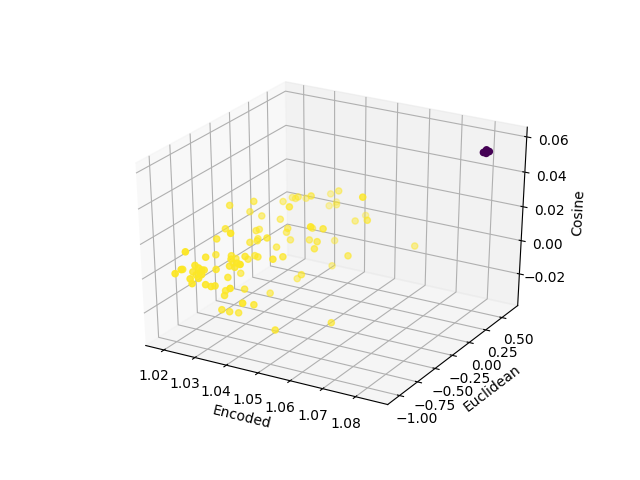

In [23]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(test_z[:N,1],test_z[:N,0], test_z[:N,2], c=test_labels[:N].astype(int))
ax.set_xlabel('Encoded')
ax.set_ylabel('Euclidean')
ax.set_zlabel('Cosine')
plt.show()

In [137]:
test_energy.shape

(100,)

In [24]:
%matplotlib inline

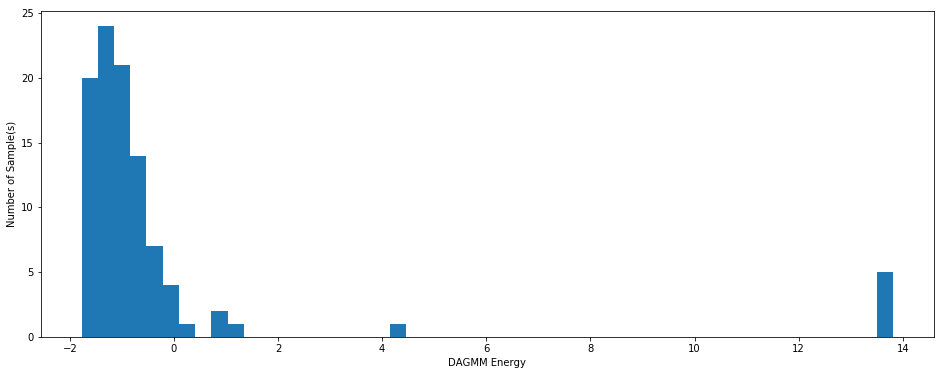

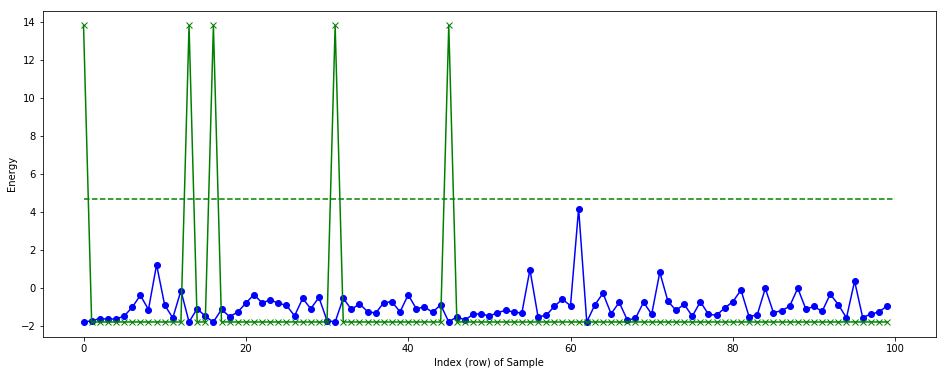

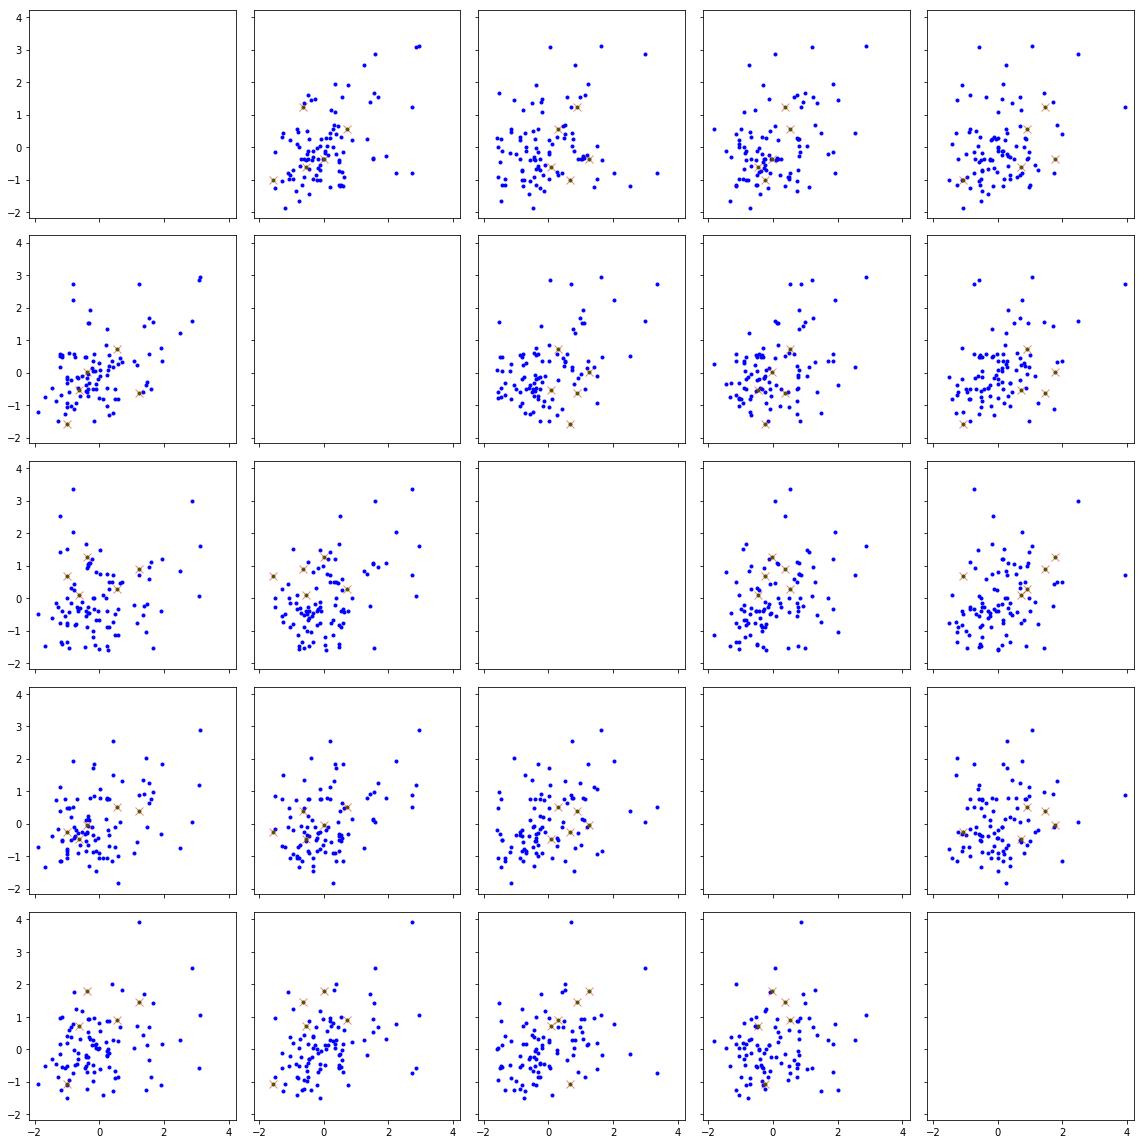

In [25]:
energy = test_energy
anomaly_index = test_labels == 0
normal_index = test_labels == 1
data = solver.data_loader.dataset.test


plt.figure(figsize=[16,6])
histinfo = plt.hist(energy, bins=50)
plt.xlabel("DAGMM Energy")
plt.ylabel("Number of Sample(s)")
# plt.savefig("./dagm2007_class1_energy_hist.png")
plt.show()

plt.figure(figsize=[16,6])
normal_energy = energy.copy()
anomaly_energy = energy.copy()
normal_energy[anomaly_index] = normal_energy[normal_index].min()
anomaly_energy[normal_index] = normal_energy[normal_index].min()
plt.plot(normal_energy, "o-", c='b')
plt.plot(anomaly_energy, "x-", c='g')
plt.hlines(np.percentile(energy, 95), 0, 100, 'g', linestyles='dashed')
plt.xlabel("Index (row) of Sample")
plt.ylabel("Energy")
# plt.savefig("./dagm2007_class1_energy.png")
plt.show()

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=[16,16], sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for row in range(5):
    for col in range(5):
        ax = axes[row, col]
        if row != col:
            ax.plot(data[normal_index,col], data[normal_index,row], ".", c='b')
            ax.plot(data[anomaly_index,col], data[anomaly_index,row], ".", c='g')
            ano_index = np.arange(len(energy))[energy > np.percentile(energy, 95)]
            ax.plot(data[ano_index,col], data[ano_index,row], "x", c="r", alpha=0.5, markersize=8)
plt.tight_layout()
# plt.savefig("./dagm2007_scatter.png")
plt.show()